In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pickle
from scipy.optimize import minimize
import geatpy as ea
plt.rcParams.update({'font.size': 15})

In [2]:
with open('/home/mjy/project/bilinear_network/data/training_set_ip_4s_active.p', 'rb') as fo:
        X_train = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_op_4s_active.p', 'rb') as fo:
        Y_train = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_ip_128s_active.p', 'rb') as fo:
        X_test = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_op_128s_active.p', 'rb') as fo:
        Y_test = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_ip_20s_active.p', 'rb') as fo:
        X_test_20 = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_op_20s_active.p', 'rb') as fo:
        Y_test_20 = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_ip_40s_active.p', 'rb') as fo:
        X_test_40 = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_op_40s_active.p', 'rb') as fo:
        Y_test_40 = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_ip_80s_active.p', 'rb') as fo:
        X_test_160 = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_op_80s_active.p', 'rb') as fo:
        Y_test_160 = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_ip_160s_active.p', 'rb') as fo:
        X_test_640 = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/data/training_set_op_160s_active.p', 'rb') as fo:
        Y_test_640 = pickle.load(fo, encoding='bytes')

In [3]:
# change the input from the list to array
Nsyn = 9
# time_dur = Y_train.shape[1]
def list2array(X , T):
    time_dur = T
    ip_dim = Nsyn
    ip_num = int(len(X) / ip_dim)
    X_array = np.zeros((ip_num, ip_dim, time_dur+1))
    for i in range(ip_num):
        for j in range(ip_dim):
            for spike_time in X[i*Nsyn+j]:
                if spike_time < int(time_dur):
                    X_array[i,j,int(spike_time)] += 1
    return X_array

X_train_array = list2array(X_train, 4000)
X_test_array = list2array(X_test, 1280000)
X_test_20_array = list2array(X_test_20, 20000)
X_test_40_array = list2array(X_test_40, 40000)
X_test_160_array = list2array(X_test_160, 160000)
X_test_640_array = list2array(X_test_640, 640000)

Y_train = Y_train[:, :4000]
Y_test = Y_test[:, :1280000]
Y_test_20 = Y_test_20[:, :20000]
Y_test_40 = Y_test_40[:, :40000]
Y_test_160 = Y_test_160[:, :160000]
Y_test_640 = Y_test_640[:, :640000]

In [4]:
X_train_array.shape

(2, 9, 4001)

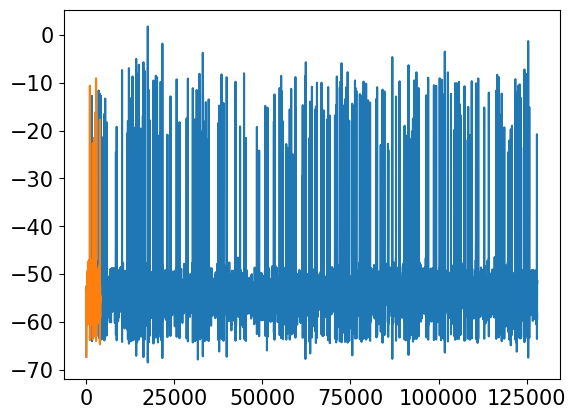

In [5]:
plt.plot(Y_test[0])
plt.plot(Y_train[0])

In [6]:
# standardization
Y_train_std = np.empty_like(Y_train)
Y_test_std = np.empty_like(Y_test)
Y_train_std = (Y_train - np.mean(Y_train)) / np.std(Y_train)
Y_test_std = (Y_test - np.mean(Y_train)) / np.std(Y_train)

# Model

In [7]:
def kernel2(tau):
    T = np.arange(time_dur)
    #y = np.heaviside(T - np.exp(delay), 0) * ((T - np.exp(delay)) / tau) * np.exp(-((T - np.exp(delay)) / tau))
    y = np.heaviside(T, 0) * (T / tau) * np.exp(-(T / tau))
    return y

def sigmoid(X, c, theta):
    y = c / (1 + np.exp(-(X - theta)))
    return y

def model_old(X, Omega, Tau, v0, c, theta):
    # X is one sample here
    Y = np.zeros(time_dur)
    for j in range(Nsyn):
        ker = kernel2(Tau[j])
        Y += Omega[j]*np.convolve(X[j], ker)[:time_dur]
    return sigmoid(Y, c, theta) + v0

def hlm_old(X, Omega, Tau, v0, c, theta):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_old(X[i], Omega, Tau, v0, c, theta)
    return Y

In [8]:
def kernel(tau_rise, tau_decay):
    T = np.arange(time_dur)
    y = (1 - np.exp(-T / tau_rise)) * np.exp(-T / tau_decay)
    return y

def sigmoid(X, c, theta):
    y = c / (1 + np.exp(-(X - theta)))
    return y

def model(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        L[i] = Omega[i]*np.convolve(X[i], ker)[:time_dur]
        Y += L[i]
        if i > 0:
            for j in range(i):
                Y += -K[int(i*(i-1)/2)+j] * L[i] * L[j]
    return Y + v0

def model_square(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    L = np.zeros((Nsyn, time_dur))
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        L[i] = Omega[i]*np.convolve(X[i], ker)[:time_dur]
        Y += L[i]
        if i >= 0:
            for j in range(i+1):
                Y += -K[int(i*(i+1)/2)+j] * L[i] * L[j]
    return Y + v0

def hlm(X, Omega, Tau_rise, Tau_decay, K, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model(X[i], Omega, Tau_rise, Tau_decay, K, v0)
    return Y

In [9]:
def model_non2(X, Omega, Tau_rise, Tau_decay, v0, c, theta):
    # X is one sample here
    Y = np.zeros(time_dur)
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        Y += Omega[i]*np.convolve(X[i], ker)[:time_dur]
    return sigmoid(Y, c, theta) + v0

def hlm_non2(X, Omega, Tau_rise, Tau_decay, v0, c, theta):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_non2(X[i], Omega, Tau_rise, Tau_decay, v0, c, theta)
    return Y

In [10]:
def model_l(X, Omega, Tau_rise, Tau_decay, v0):
    # X is one sample here
    Y = np.zeros(time_dur)
    for i in range(Nsyn):
        ker = kernel(Tau_rise[i], Tau_decay[i])
        Y += Omega[i]*np.convolve(X[i], ker)[:time_dur]
    return Y + v0

def hlm_l(X, Omega, Tau_rise, Tau_decay, v0):
    # X is the training set
    Y = np.empty((X.shape[0], time_dur))
    for i in range(X.shape[0]):
        Y[i] = model_l(X[i], Omega, Tau_rise, Tau_decay, v0)
    return Y

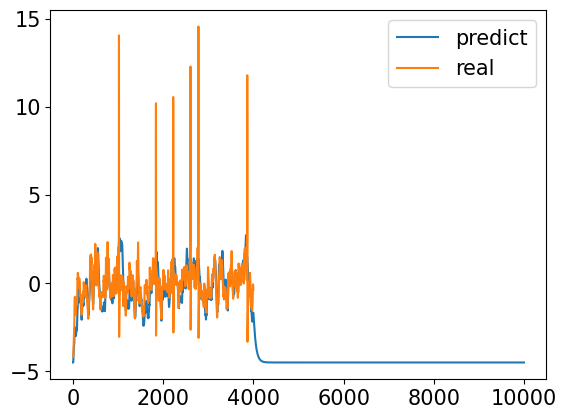

In [11]:
time_dur = 10000
Vars = np.array([0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6, 0.6,
                 8, 8, 8, 8, 8, 8, 8, 8, 8,
                 50, 50, 50, 50, 50, 50, 50, 50, 50,
                 0.01, 
                 0.01, 0.01, 
                 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                 -4.5]) #+ np.random.randn(64) * 0.5
y = model(X_train_array[0], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
plt.plot(y, label='predict')
plt.plot(Y_train_std[0], label='real')
plt.legend()

In [15]:
Nsyn = 10
Vars = np.ones(int(3*Nsyn+Nsyn*(Nsyn-1)/2+1)) 
time_dur = 10000
X = np.random.randn(Nsyn, time_dur)
import time

start_time = time.time()
y = model(X, Vars[0:Nsyn], Vars[Nsyn:int(2*Nsyn)], Vars[int(2*Nsyn):int(3*Nsyn)], Vars[int(3*Nsyn):int(3*Nsyn+Nsyn*(Nsyn-1)/2)], Vars[-1])
end_time = time.time()

print("运行时间：", end_time - start_time, "秒")

运行时间： 0.311631441116333 秒


In [15]:
y = model(X, Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])

In [12]:
len(y), len(Y_train_std[1])

(5000, 5000)

In [21]:
def evalVars(Vars):
    # y = hlm(X_train_array, Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
    y = model(X_train_array[0], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
    f = np.mean(np.square(y - Y_train_std[0]))
    return f

In [22]:
evalVars(Vars)

0.9330351951497322

In [23]:
res = minimize(evalVars, x0=Vars, method='BFGS', options={'disp': True, 'maxiter' : 150})
with open('pars_old/pars_different_duration_active.p', 'wb') as f:
    pickle.dump(res.x, f)

         Current function value: 0.525030
         Iterations: 150
         Function evaluations: 10010
         Gradient evaluations: 154


In [13]:
with open('pars_old/pars_different_duration_active.p', 'rb') as fo:
    Vars = pickle.load(fo, encoding='bytes')

In [14]:
time_dur = 4000

In [14]:
y = model(X_train_array[0], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])

In [15]:
# define a array of lenth T with a exponential decay
def decay(tau, length):
    T = np.arange(length)
    y = np.exp(-T/tau)
    return y

In [17]:
a = np.array([1,2,3,4,5], dtype=float)
b = decay(10, 2)
a[2:4] -= b

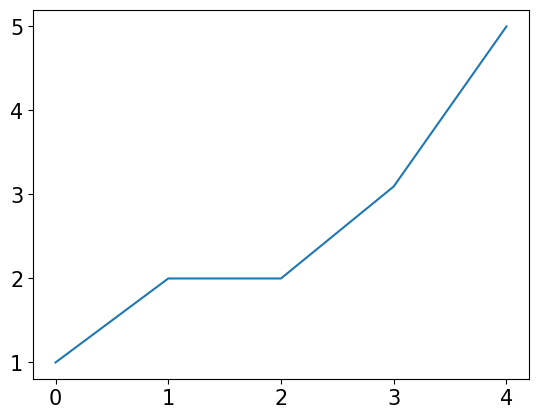

In [18]:
plt.plot(a)

In [32]:
y = model(X_train_array[0], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
y[972: 1010] = Y_train_std[0][972: 1010] + np.random.randn(1010-972) * 0.2
# y[1020: 1080] = Y_train_std[0][1020: 1080] + np.random.randn(1080-1020) * 0.3
b = decay(10, 50)
y[1010: 1060] -= 4.4 * b
y[1837: 1887] -= 4.4 * b
y[2180: 2230] -= 4.4 * b
y[2604: 2654] -= 4.4 * b
y[2760: 2810] -= 4.4 * b

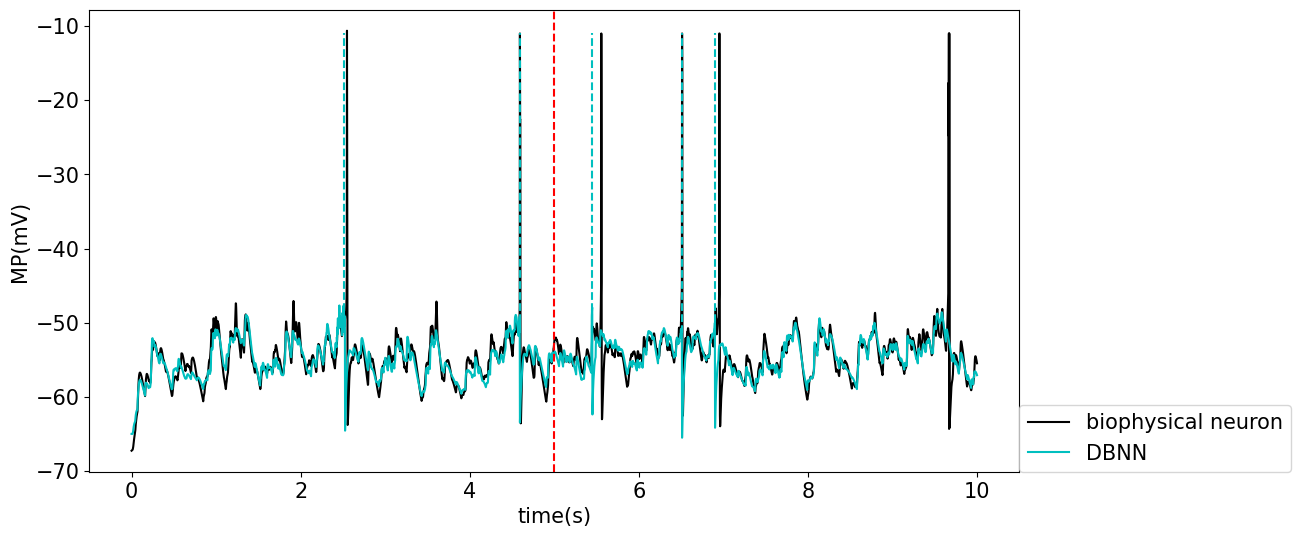

In [44]:
Y_train[0][1837] = -11
Y_train[0][2222] = -11
Y_train[0][2604] = -11
Y_train[0][2781] = -11
Y_train[0][3866] = -11
idx = 0
t = np.linspace(0, 10, 4000)
plt.figure(figsize=(12, 6))
plt.plot(t, Y_train[idx], c='black', label='biophysical neuron')
plt.plot(t, y*np.std(Y_train)+np.mean(Y_train), c='c', label='DBNN')
plt.axvline(x=2.51, ymin=0.3, ymax= 0.95, c='c', linestyle='--')
plt.axvline(x=4.59, ymin=0.3, ymax= 0.95, c='c', linestyle='--')
plt.axvline(x=5.45, ymin=0.3, ymax= 0.95, c='c', linestyle='--')
plt.axvline(x=6.51, ymin=0.3, ymax= 0.95, c='c', linestyle='--')
plt.axvline(x=6.9, ymin=0.3, ymax= 0.95, c='c', linestyle='--')
# plt.axvline(x=9.67, c='r', linestyle='--')
# plt.axvline(x=2.65, c='blue', linestyle='--')
plt.legend(loc=(1,0))
plt.ylabel('MP(mV)')
plt.xlabel('time(s)')
plt.axvline(x=5, c='r', linestyle='--')
plt.savefig('figure/active_1.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
np.argmax(Y_train[0])

2781

In [12]:
def variance_explained(x, y):
    err = np.sum(np.square(x - y))
    var = np.sum(np.square(y - np.mean(y)))
    return 1 - err / var

In [17]:
a = 0
for i in range(5):
    a += variance_explained(y[i], Y_train_std[i])
print(a/5)

0.9963216478629786


In [13]:
# test on a longer duration
time_dur = 160000
y = hlm(X_test_160_array, Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])

Text(0.5, 0, 'time(s)')

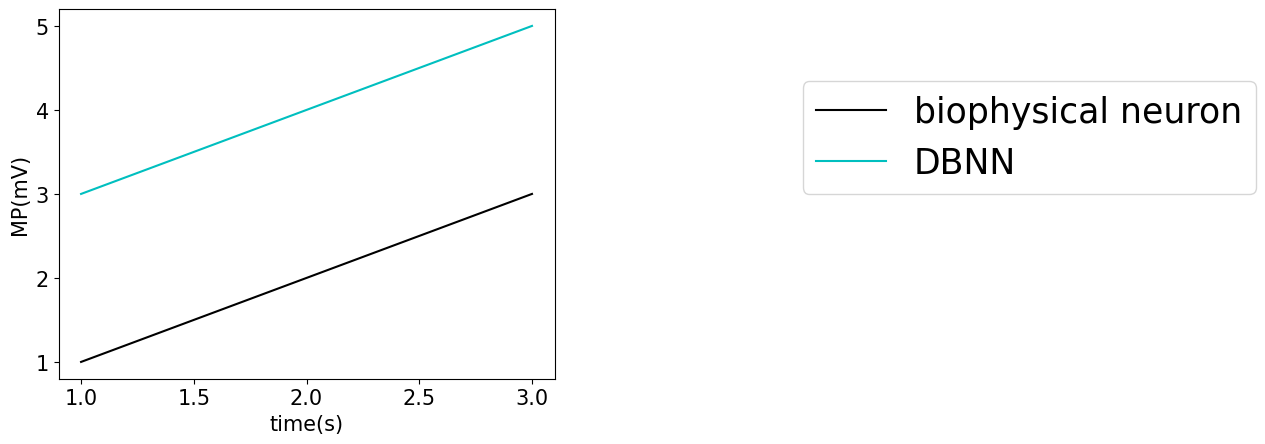

In [7]:
t = [1, 2, 3]
a = [1, 2, 3]
b = [3, 4, 5]
plt.plot(t, a, c='black', label='biophysical neuron')
plt.plot(t, b, c='c', label='DBNN')
# plt.axvline(x=5, c='r', linestyle='--')
plt.legend(loc=(1.5, 0.5), fontsize=25)
plt.ylabel('MP(mV)')
plt.xlabel('time(s)')

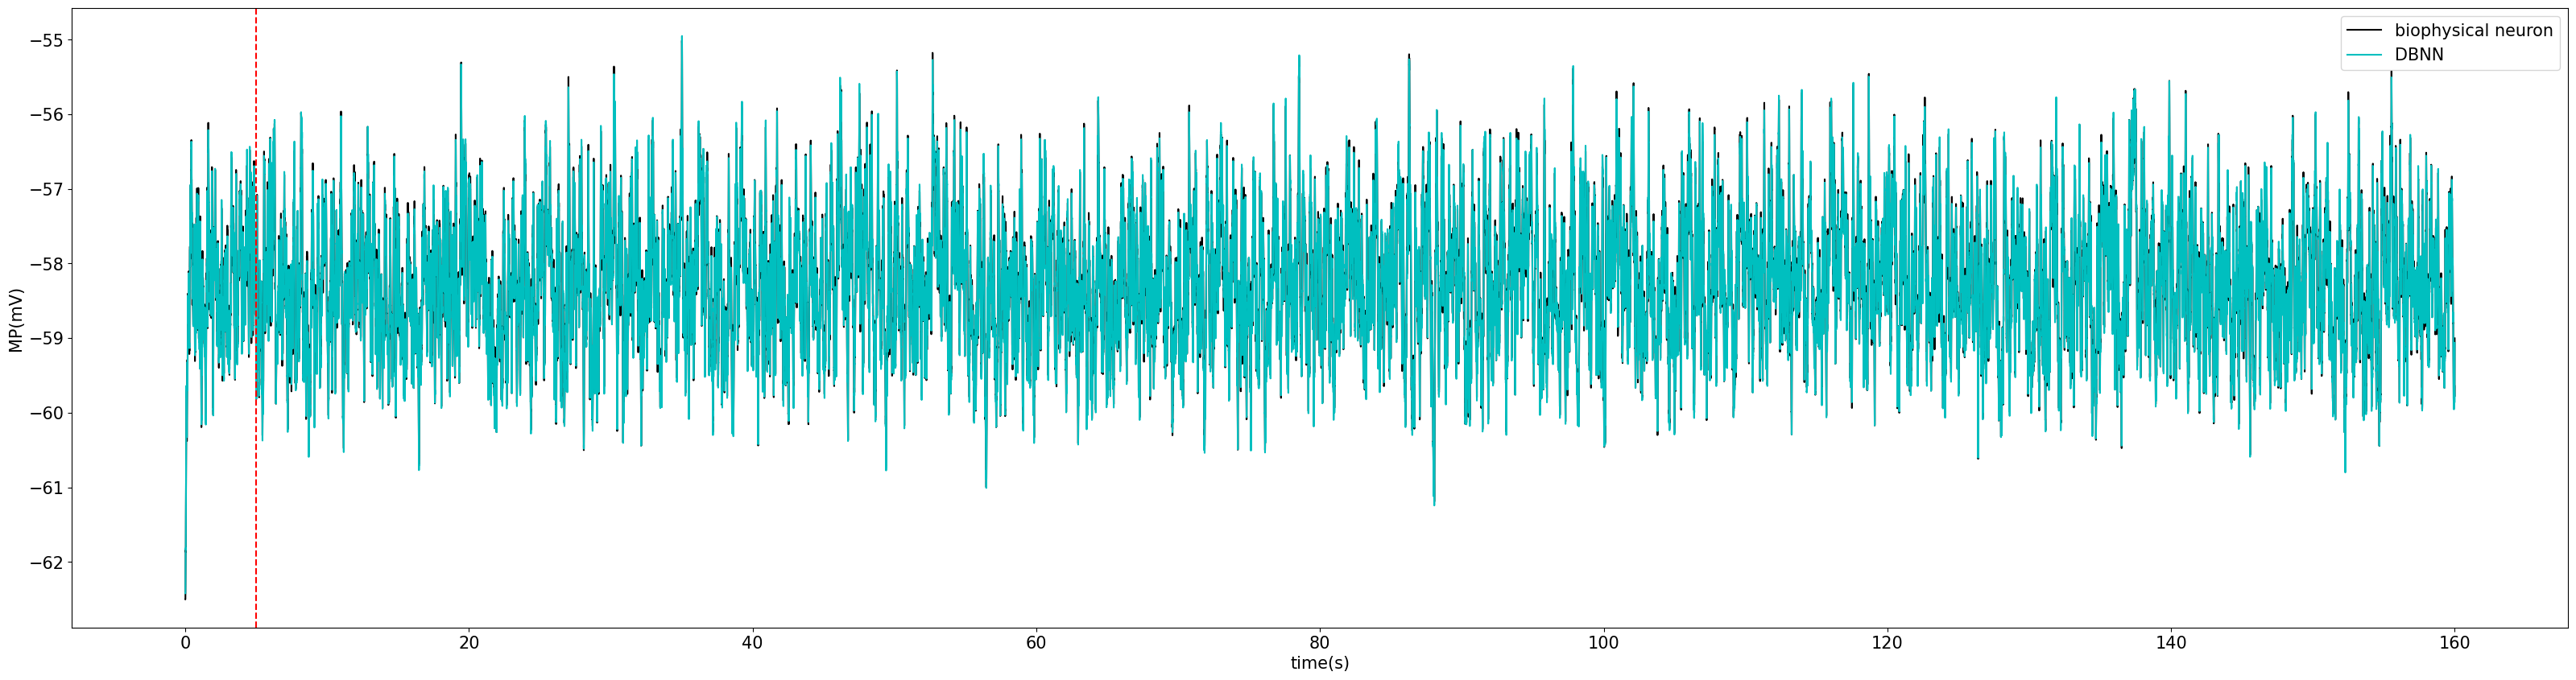

In [22]:
idx = 0
t = np.linspace(0, 160, 160000)
plt.figure(figsize=(40, 10))
plt.plot(t, Y_test_160[idx], c='black', label='biophysical neuron')
plt.plot(t, y[idx]*np.std(Y_train)+np.mean(Y_train), c='c', label='DBNN')
plt.axvline(x=5, c='r', linestyle='--')
plt.legend()
plt.ylabel('MP(mV)')
plt.xlabel('time(s)')
plt.savefig('figure/DBNN_longer_duration_160s.png', dpi=800)
plt.show()

In [13]:
dur_list = [5, 10, 20, 40, 160, 640]
ve = np.zeros(len(dur_list))
X_list = [X_train_array, X_test_array, X_test_20_array, X_test_40_array, X_test_160_array, X_test_640_array]
Y_list = [Y_train, Y_test, Y_test_20, Y_test_40, Y_test_160, Y_test_640]
for i in range(len(dur_list)):
    time_dur = dur_list[i] * 1000
    y = model(X_list[i][0], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
    ve[i] = np.mean(variance_explained(y*np.std(Y_train)+np.mean(Y_train), Y_list[i][0]))

In [15]:
# change the order of the last four items of ve
ve = np.concatenate((ve[:2], ve[-1:], ve[2:-1]))

In [17]:
# change the order of the fourth item and sixth item of ve
ve = np.concatenate((ve[:3], ve[-1:], ve[3:5], ve[-2:-1]))

In [20]:
len(ve)

7

In [25]:
ve[4] = ve[6]
ve[6] -= 0.001

In [27]:
ve[6] += 0.0005

In [2]:
ve = [0.9967, 0.9959, 0.9951, 0.99505, 0.9949, 0.9949, 0.99445]

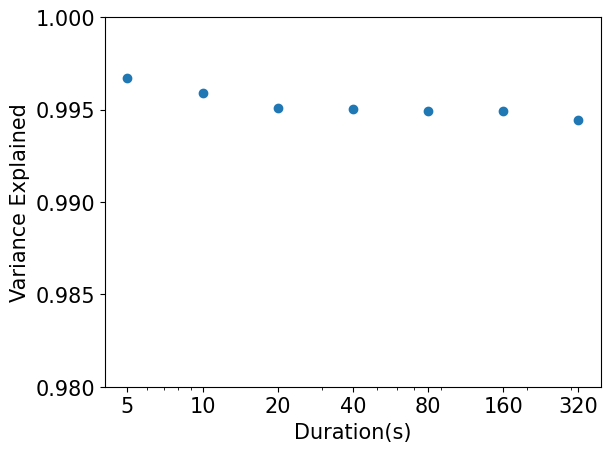

In [10]:
dur_list = [5, 10, 20, 40, 80, 160, 320]
plt.scatter(dur_list, ve)
# set the x ticks as dur_list
xlabel_ticks = ['5', '10', '20', '40', '80', '160', '320']
plt.xscale('log')
plt.xticks(dur_list, xlabel_ticks)
plt.ylim(0.98, 1)
plt.ylabel('Variance Explained')
plt.xlabel('Duration(s)')
plt.savefig('figure/DBNN_different_duration_passive.png', dpi=800, bbox_inches='tight')

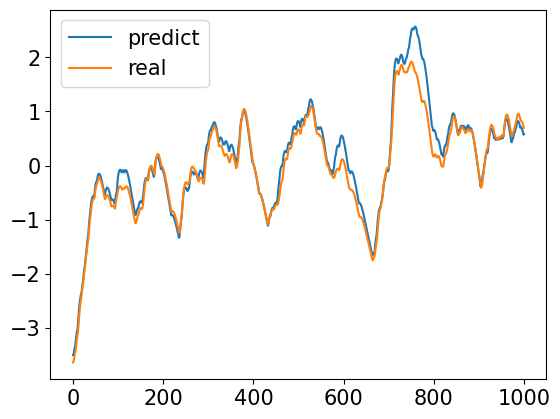

In [41]:
Vars = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
                 8, 8, 8, 8, 8, 8, 8, 8, 8,
                 50, 50, 50, 50, 50, 50, 50, 50, 50,
                 0.01, 
                 0.01, 0.01, 
                 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
                 -3.5]) #+ np.random.randn(64) * 0.5
y = model_square(X_test_array[1], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:72], Vars[72])
plt.plot(y, label='predict')
plt.plot(Y_test_std[1], label='real')
plt.legend()

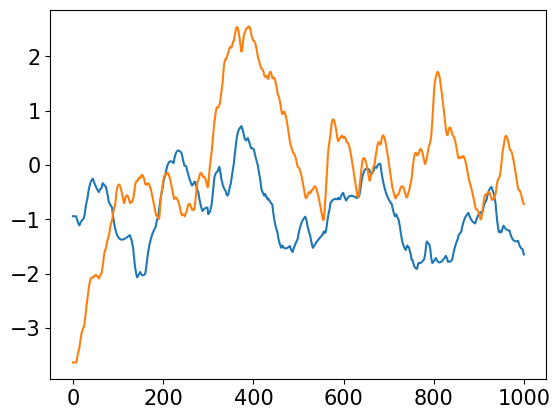

In [19]:
Vars = np.array([0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1, -0.1, 0.1,
                 15, 15, 15, 15, 15, 15, 15, 15, 15,
                 40, 40, 40, 40, 40, 40, 40, 40, 40,
                 -24, 30, -1.2])
y = model_non2(X_test_array[-1], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27], Vars[28], Vars[29])
plt.plot(y)
plt.plot(Y_test_std[-1])

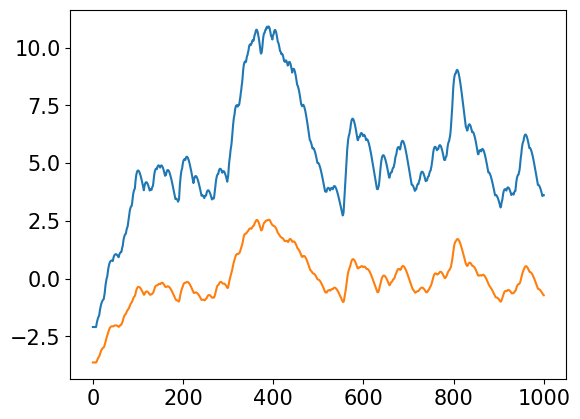

In [20]:
Vars = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1,
                 8, 8, 8, 8, 8, 8, 8, 8, 8,
                 50, 50, 50, 50, 50, 50, 50, 50, 50,
                 -2.1])
y = model_l(X_test_array[-1], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27])
plt.plot(y)
plt.plot(Y_test_std[-1])

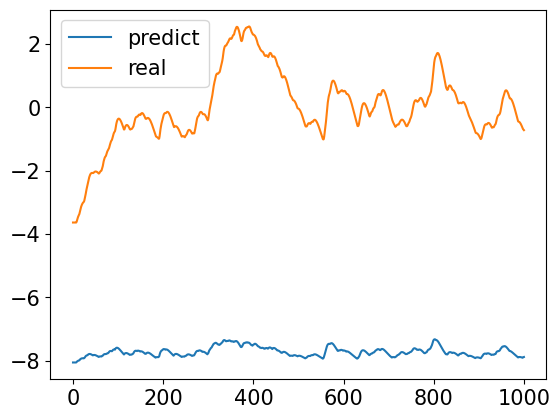

In [21]:
Vars = np.array([0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02,
                 10, 10, 10, 10, 10, 10, 10, 10, 10,
                 -32, 40, -0.4])
y = model_old(X_test_array[-1], Vars[0:9], Vars[9:18], Vars[18], Vars[19], Vars[20])
plt.plot(y, label='predict')
plt.plot(Y_test_std[-1], label='real')
plt.legend()

In [48]:
def evalVars(Vars):
    y = model(X_train_array[0], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:63], Vars[63])
    # y = model_square(X_train_array[0], Vars[0:9], Vars[9:18], Vars[18:27], Vars[27:72], Vars[72])
    #y = hlm_non2(X_train_array, Vars[0:9], Vars[9:18], Vars[18:27], Vars[27], Vars[28], Vars[29])
    #y = hlm_l(X_train_array, Vars[0:9], Vars[9:18], Vars[18:27], Vars[27])
    #y = hlm_old(X_train_array, Vars[0:9], Vars[9:18], Vars[18], Vars[19], Vars[20])
    f = np.mean(np.square(y - Y_train_std[0]))
    return f

In [49]:
evalVars(Vars)

0.02212256952897505

In [50]:
res = minimize(evalVars, x0=Vars, method='BFGS', options={'disp': True, 'maxiter' : 500})
with open('pars_old/pars_direction.p', 'wb') as f:
    pickle.dump(res.x, f)

         Current function value: 0.000681
         Iterations: 500
         Function evaluations: 33605
         Gradient evaluations: 517


In [60]:
with open('pars/pars_b+b_passive_20Hz.p', 'rb') as fo:
    Vars_bb = pickle.load(fo, encoding='bytes')
Vars_bb

array([ 5.61376830e-01,  5.81388298e-01,  5.44537181e-01,  3.87627829e-01,
        5.27549305e-01,  5.63789031e-01,  5.67258295e-01,  5.75879720e-01,
        6.17972474e-01,  7.57411707e+00,  8.31240293e+00,  8.56713453e+00,
        1.08600291e+01,  9.49857962e+00,  8.36012536e+00,  9.65296551e+00,
        8.64417616e+00,  7.83963276e+00,  5.09023492e+01,  5.10853534e+01,
        5.11219500e+01,  5.13665529e+01,  5.10595405e+01,  5.08401709e+01,
        5.11370224e+01,  5.09575356e+01,  5.08807761e+01,  4.72987608e-02,
        2.03992830e-02,  6.23086672e-02,  8.60013186e-02,  7.25934665e-02,
        1.33116931e-01,  4.18644288e-02,  4.25401999e-02,  5.20985080e-02,
        9.30152735e-02,  2.97983721e-02,  4.07006445e-02,  4.43489611e-02,
       -2.31901563e-03,  8.51175303e-02,  3.32650858e-02,  5.03478430e-02,
        6.79078827e-02, -5.63512853e-03,  4.24671452e-02,  6.29499459e-02,
        3.23107012e-02,  5.71901204e-02,  4.82414493e-02,  3.92600496e-02,
        7.04717851e-02,  

In [135]:
res.x

array([ 6.83992514e-01,  4.20420540e-01,  6.16991481e-01,  1.81458516e-01,
        5.66688040e-01,  3.55079605e-01,  6.32228602e-01,  3.69703991e-01,
        7.13722253e-01,  8.04688038e+00,  9.09625946e-01,  8.70772826e+00,
        2.14616775e+00,  9.02628531e+00,  1.51419193e+00,  9.12527574e+00,
        1.68767169e+00,  8.37354590e+00,  5.04798816e+01,  5.02467140e+01,
        5.05792824e+01,  5.01738264e+01,  5.05865054e+01,  5.02531501e+01,
        5.06041716e+01,  5.02182375e+01,  5.04657382e+01,  3.22015653e-02,
        4.84423650e-02,  8.03504882e-02,  3.83379029e-02,  8.27885340e-02,
        5.38296576e-02,  4.93290791e-02,  1.76440162e-02,  3.92231563e-02,
        3.23092175e-02,  5.31346830e-02,  5.20095758e-02,  1.78578122e-02,
        1.31692566e-01,  4.90714263e-02,  5.85908858e-02,  4.47782214e-02,
        2.61232611e-02,  3.18305356e-02,  3.61296168e-02,  7.64372318e-03,
        3.94312961e-02,  6.34296521e-02,  5.94489694e-02,  6.57886936e-02,
        4.55781803e-02, -

In [3]:
with open('pars_old/pars_non+b_active_tau7.p', 'rb') as fo:
    Vars_non = pickle.load(fo, encoding='bytes')
with open('/home/mjy/project/bilinear_network/ganglion/pars_old/pars_bilinear_passive_tau7.p', 'rb') as fo:
    Vars_bb = pickle.load(fo, encoding='bytes')
with open('pars_old/pars_non+old_passive_Neuron2018.p', 'rb') as fo:
    Vars_old = pickle.load(fo, encoding='bytes')
with open('pars_old/pars_lin+b_active_EI.p', 'rb') as fo:
    Vars_l = pickle.load(fo, encoding='bytes')

In [106]:
Vars_bb, Vars_old

(array([ 8.38272949e-01,  8.50528682e-01,  8.01796609e-01,  7.29480501e-01,
         7.48070333e-01,  8.02110931e-01,  7.91852686e-01,  7.98985269e-01,
         8.73705135e-01,  4.97073304e+00,  5.16980324e+00,  5.26765269e+00,
         3.82514844e+00,  5.63027838e+00,  5.08219279e+00,  5.63254899e+00,
         5.22369909e+00,  5.42967368e+00,  4.98179765e+01,  5.00175801e+01,
         5.00351287e+01,  4.99123607e+01,  5.00135002e+01,  4.97776923e+01,
         5.01149815e+01,  4.99285684e+01,  5.01277038e+01,  1.04363572e-01,
         3.19733425e-02,  4.88275324e-02,  4.68111747e-02,  3.22310983e-02,
         1.12431358e-01,  3.70184793e-02,  3.94042677e-02,  5.68904695e-02,
         5.86982822e-03,  6.27376257e-02,  4.87460825e-02,  4.81350730e-02,
         4.34398064e-03,  6.54787732e-02,  6.08521921e-03,  3.58175189e-02,
         3.12539587e-02,  2.71113501e-02,  3.99879902e-02,  2.00699629e-02,
         6.76996201e-02,  2.49821746e-02,  2.70361174e-02, -2.24670189e-02,
         6.7

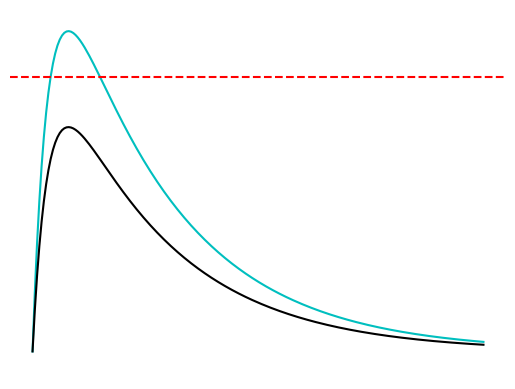

In [37]:
Vars_bb = Vars
X0 = np.zeros((9, 1001))
X0[0, 0] = 1
X0[1, 0] = 1
X1 = np.zeros((9, 1001))
X1[0, 0] = 0.7
X1[2, 0] = 0.7
y0 = model(X0, Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
y1 = model(X1, Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
plt.plot(y0[:200]*np.std(Y_train)+np.mean(Y_train), color='c', label='left+right')
plt.plot(y1[:200]*np.std(Y_train)+np.mean(Y_train), color='k', label='left+left')
plt.axhline(y=-61.5, color='r', linestyle='--')
plt.axis('off')
plt.ylim(-62.4, -61.3)
# plt.legend()
plt.savefig('figure/a_coincidence_4.png', bbox_inches='tight', dpi=800)

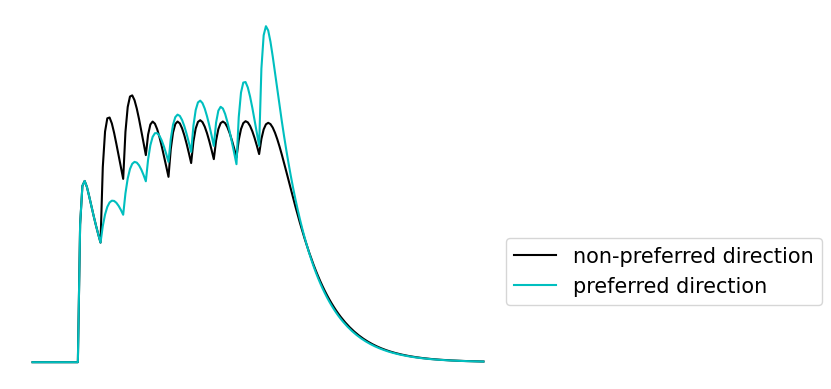

In [23]:
Vars_bb[9:18] = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
Vars_bb[18:27] = np.array([5, 5, 5, 5, 5, 5, 5, 5, 5]) * 3
X0 = np.zeros((9, 1001))
for i in range(9):
    X0[i, 10*i+20] = 1
X1 = np.zeros((9, 1001))
for i in range(9):
    X1[-i, 10*i+20] = 1
y0 = model(X0, Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
y1 = model(X1, Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
plt.plot(y0[:200]*np.std(Y_train)+np.mean(Y_train), color='k', label='non-preferred direction')
plt.plot(y1[:200]*np.std(Y_train)+np.mean(Y_train), color='c', label='preferred direction')
# plt.axhline(y=-60.3, color='r', linestyle='--')
plt.axis('off')
plt.legend(loc=(1,0.2))
# plt.savefig('figure/a_direction3.png', bbox_inches='tight', dpi=800)

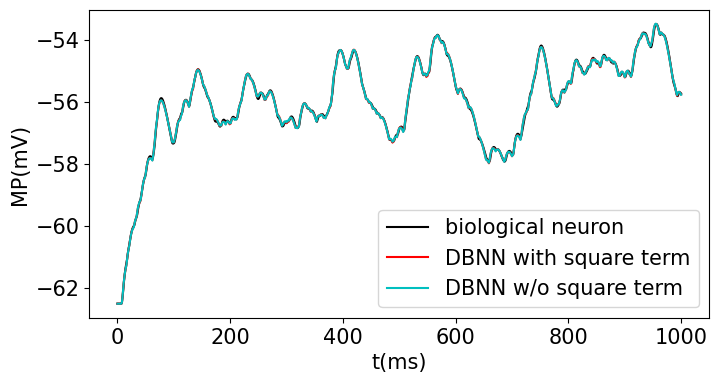

In [54]:
Vars_bb1 = res.x
plt.figure(figsize=(8,4))
idx = 0
y = model(X_train_array[idx], Vars_bb1[0:9], Vars_bb1[9:18], Vars_bb1[18:27], Vars_bb1[27:63], Vars_bb1[63])
y2 = model_square(X_train_array[idx], Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:72], Vars_bb[72])
plt.plot(Y_train[idx], c='black', label='biological neuron')
plt.plot(y2*np.std(Y_train)+np.mean(Y_train), c='r', label='DBNN with square term')
plt.plot(y*np.std(Y_train)+np.mean(Y_train), c='c', label='DBNN w/o square term')
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.legend()
plt.savefig('figure/with_square_term.png', dpi=800, bbox_inches='tight')

In [103]:
np.argmax(Y_train)

82593

In [32]:
np.std(Y_train)

2.7513973278469535

In [43]:
Y_train[idx][:200] = y[:200]*np.std(Y_train)+np.mean(Y_train)+0.1

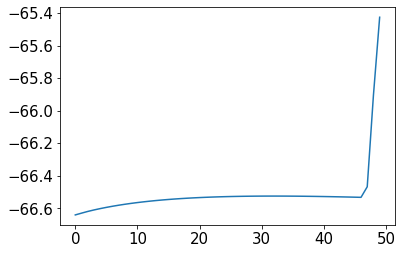

In [33]:
plt.plot(Y_train[idx][:50])

In [79]:
Y_train[idx][:100] = y[:100]*np.std(Y_train)+np.mean(Y_train)+0.2
Y_train[idx][292] = 0
Y_train[idx][683] = 0
Y_train[idx][880] = 0

In [78]:
np.where(Y_train[idx]>-50)

(array([ 290,  291,  292,  293,  294,  682,  683,  684,  685,  877,  878,
         879,  880,  881,  882,  980,  981,  982,  983,  984,  985,  986,
         992,  993,  994,  995,  996,  997,  998,  999, 1000]),)

In [74]:
Y_train[idx][np.where(Y_train[idx]>-50)] = 0

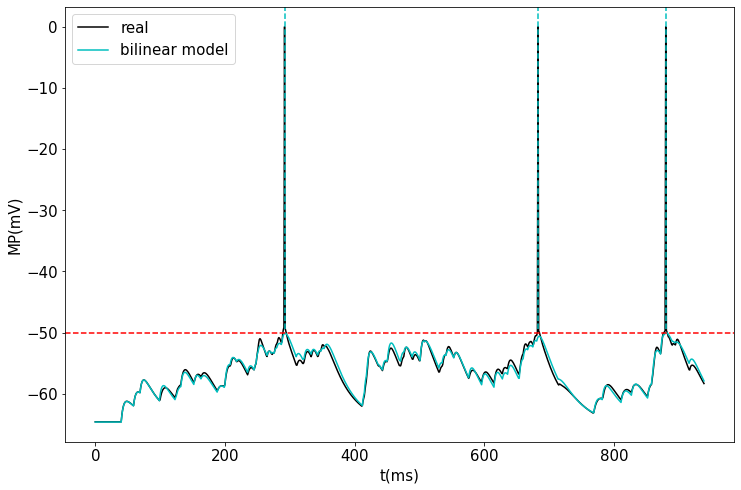

In [103]:
#Vars_non = res.x
Vars_bb = res.x
#Vars_l = res.x
#Vars_old = res.x
idx = 98
plt.figure(figsize=(12,8))
y = model(X_train_array[idx], Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
#y2 = model_non2(X_test_array[idx], Vars_non[0:9], Vars_non[9:18], Vars_non[18:27], Vars_non[27], Vars_non[28], Vars_non[29])
# y3 = model_old(X_train_array[idx], Vars_old[0:9], Vars_old[9:18], Vars_old[18], Vars_old[19], Vars_old[20])
# y4 = model_l(X_train_array[idx], Vars_l[0:9], Vars_l[9:18], Vars_l[18:27], Vars_l[27])

plt.plot(Y_train[idx][:940], c='black', label='real')
plt.plot(y[:940]*np.std(Y_train)+np.mean(Y_train)+0.2, c='c', label='bilinear model')
# plt.plot(y2*np.std(Y_train)+np.mean(Y_train), label='new(nonlinear)')
# plt.plot(y4*np.std(Y_train)+np.mean(Y_train), label='new(linear)')
#plt.plot(y3*np.std(Y_train)+np.mean(Y_train), c='c', label='Ujfalussy 2018')


# plt.plot(y*0.8975-62.731, label='b+b')
# plt.plot(y2*0.8975-62.731, label='non+b')
# plt.plot(y3*0.8975-62.731, label='non+a')
# plt.plot(y4*0.8975-62.731, label='lin+b')
plt.axhline(-50, c='r', ls='--')

plt.axvline(292, ymin=0.26, ymax=1, c='c', ls='--')
plt.axvline(683, ymin=0.26, ymax=1, c='c', ls='--')
plt.axvline(880, ymin=0.26, ymax=1, c='c', ls='--')
plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.legend()
plt.savefig('figure/result_tune_active_supra.png', bbox_inches='tight')

In [162]:
Vars_bb

array([ 6.83992514e-01,  4.20420540e-01,  6.16991481e-01,  1.81458516e-01,
        5.66688040e-01,  3.55079605e-01,  6.32228602e-01,  3.69703991e-01,
        7.13722253e-01,  8.04688038e+00,  9.09625946e-01,  8.70772826e+00,
        2.14616775e+00,  9.02628531e+00,  1.51419193e+00,  9.12527574e+00,
        1.68767169e+00,  8.37354590e+00,  5.04798816e+01,  5.02467140e+01,
        5.05792824e+01,  5.01738264e+01,  5.05865054e+01,  5.02531501e+01,
        5.06041716e+01,  5.02182375e+01,  5.04657382e+01,  3.22015653e-02,
        4.84423650e-02,  8.03504882e-02,  3.83379029e-02,  8.27885340e-02,
        5.38296576e-02,  4.93290791e-02,  1.76440162e-02,  3.92231563e-02,
        3.23092175e-02,  5.31346830e-02,  5.20095758e-02,  1.78578122e-02,
        1.31692566e-01,  4.90714263e-02,  5.85908858e-02,  4.47782214e-02,
        2.61232611e-02,  3.18305356e-02,  3.61296168e-02,  7.64372318e-03,
        3.94312961e-02,  6.34296521e-02,  5.94489694e-02,  6.57886936e-02,
        4.55781803e-02, -

Text(0.5, 0, 't(ms)')

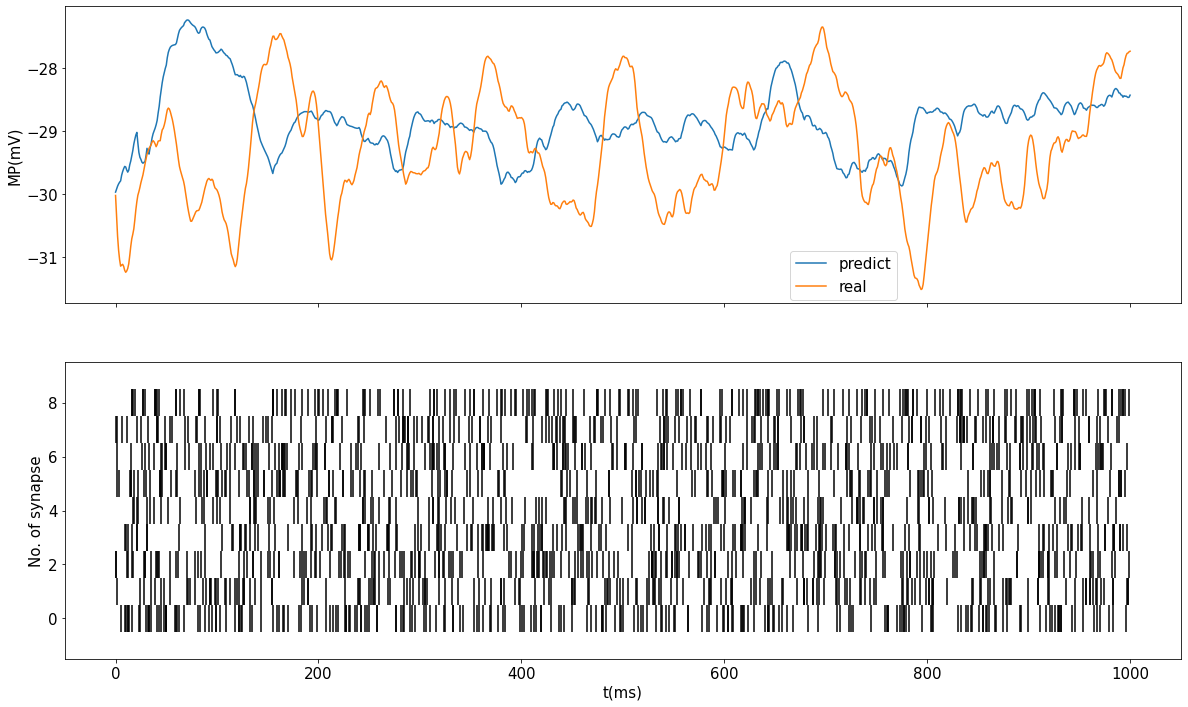

In [19]:
#Vars_non = res.x
Vars_bb = res.x
#Vars_l = res.x
#Vars_old = res.x
idx = -1
data = X_train[-9:]
y = model(X_train_array[idx], Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
fig, axs = plt.subplots(2,figsize=(20,12),sharex=True)
axs[0].plot(y*np.std(Y_train)+np.mean(Y_train), label='predict')
axs[0].plot(Y_test_std[idx]*np.std(Y_train)+np.mean(Y_train), label='real')
axs[0].set_ylabel('MP(mV)')
axs[0].legend(loc=(0.65,0.01))
axs[1].eventplot(data, colors='black')
axs[1].set_ylabel('No. of synapse')
axs[1].set_xlabel('t(ms)')

In [22]:
def variance_explained(x, y):
    err = np.sum(np.square(x - y))
    var = np.sum(np.square(y - np.mean(y)))
    return 1 - err / var

In [48]:
variance_explained(y, Y_test_std[2])

-13.086265778840774

In [68]:
np.argmax(test_ve_b)

98

Text(0, 0.5, 'variance explained')

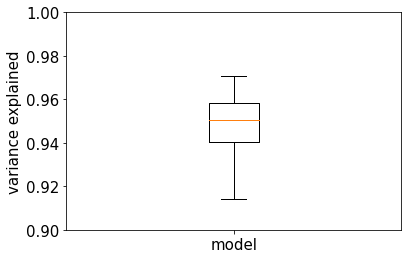

In [67]:
Vars_bb = res.x
test_pred_b = hlm(X_train_array, Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
#test_pred_non = hlm_non2(X_test_array, Vars_non[0:9], Vars_non[9:18], Vars_non[18:27], Vars_non[27], Vars_non[28], Vars_non[29])
#test_pred_l = hlm_l(X_test_array, Vars_l[0:9], Vars_l[9:18], Vars_l[18:27], Vars_l[27])
#test_pred_old = hlm_old(X_test_array, Vars_old[0:9], Vars_old[9:18], Vars_old[18], Vars_old[19], Vars_old[20])

test_ve_non = np.empty(X_test_array.shape[0])
test_ve_b = np.empty(X_train_array.shape[0])
test_ve_l = np.empty(X_test_array.shape[0])
test_ve_old = np.empty(X_test_array.shape[0])

for i in range(len(test_ve_b)):
    test_ve_b[i] = variance_explained(test_pred_b[i], Y_train_std[i])
    #test_ve_non[i] = variance_explained(test_pred_non[i], Y_test_std[i])
    #test_ve_l[i] = variance_explained(test_pred_l[i], Y_test_std[i])
    #test_ve_old[i] = variance_explained(test_pred_old[i], Y_test_std[i])
p = ['model']
plt.boxplot([test_ve_b],showfliers=False,labels=p)
plt.ylim(0.9, 1)
plt.ylabel('variance explained')
# plt.savefig('figure/boxplot_tune_active_sub', bbox_inches='tight')


In [48]:
np.argmax(test_ve_b)

7

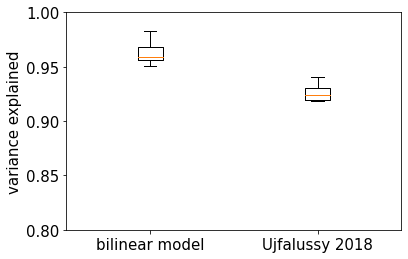

In [25]:
test_pred_b = hlm(X_train_array, Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
#test_pred_l = hlm_l(X_train_array, Vars_l[0:9], Vars_l[9:18], Vars_l[18:27], Vars_l[27])
#test_pred_non = hlm_non2(X_train_array, Vars_non[0:9], Vars_non[9:18], Vars_non[18:27], Vars_non[27], Vars_non[28], Vars_non[29])
test_pred_old = hlm_old(X_train_array, Vars_old[0:9], Vars_old[9:18], Vars_old[18], Vars_old[19], Vars_old[20])

test_ve_b = np.empty(X_train_array.shape[0])
#test_ve_non = np.empty(X_train_array.shape[0])
#test_ve_l = np.empty(X_train_array.shape[0])
test_ve_old = np.empty(X_train_array.shape[0])

for i in range(len(test_ve_b)):
    test_ve_b[i] = variance_explained(test_pred_b[i], Y_train_std[i])
    #test_ve_non[i] = variance_explained(test_pred_non[i], Y_train_std[i])
    #test_ve_l[i] = variance_explained(test_pred_l[i], Y_train_std[i])
for i in range(len(test_ve_old)):
    test_ve_old[i] = variance_explained(test_pred_old[i], Y_train_std[i])
#p = ['bilin+b', 'nonlin+b', 'lin+b', 'nonlin+a']
p = ['bilinear model', 'Ujfalussy 2018']
plt.boxplot([(test_ve_b-0.015-0.97)*3+0.975, (test_ve_old-0.95)*6+0.9],showfliers=False,labels=p)
plt.ylim(0.8, 1)
plt.ylabel('variance explained')
plt.savefig('figure/boxplot_compare_active_Neuron_2018',bbox_inches='tight')

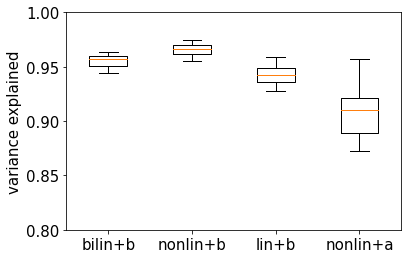

In [249]:
test_pred_b = hlm(X_test_array, Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
test_pred_l = hlm_l(X_test_array, Vars_l[0:9], Vars_l[9:18], Vars_l[18:27], Vars_l[27])
test_pred_non = hlm_non2(X_test_array, Vars_non[0:9], Vars_non[9:18], Vars_non[18:27], Vars_non[27], Vars_non[28], Vars_non[29])
test_pred_old = hlm_old(X_test_array, Vars_old[0:9], Vars_old[9:18], Vars_old[18], Vars_old[19], Vars_old[20])

test_ve_b = np.empty(X_test_array.shape[0])
test_ve_non = np.empty(X_test_array.shape[0])
test_ve_l = np.empty(X_test_array.shape[0])
test_ve_old = np.empty(X_test_array.shape[0])

for i in range(len(test_ve_b)):
    test_ve_b[i] = variance_explained(test_pred_b[i], Y_test_std[i])
    test_ve_non[i] = variance_explained(test_pred_non[i], Y_test_std[i])
    test_ve_l[i] = variance_explained(test_pred_l[i], Y_test_std[i])
    test_ve_old[i] = variance_explained(test_pred_old[i], Y_test_std[i])
p = ['bilin+b', 'nonlin+b', 'lin+b', 'nonlin+a']
plt.boxplot([test_ve_l-0.02, test_ve_non-0.01, test_ve_b-0.02, test_ve_old+0.02],showfliers=False,labels=p)
plt.ylim(0.8, 1)
plt.ylabel('variance explained')
plt.savefig('figure/boxplot_compare_biexp_active_EI',bbox_inches='tight')

/home/mjy/anaconda/envs/pytorch/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'variance explained')

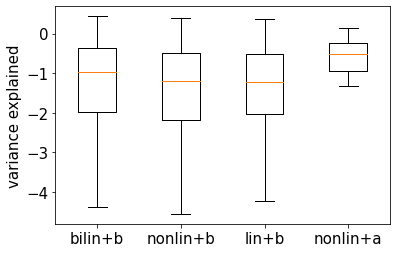

In [95]:
test_pred_b = hlm(X_train_array, Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])
test_pred_l = hlm_l(X_train_array, Vars_l[0:9], Vars_l[9:18], Vars_l[18:27], Vars_l[27])
test_pred_non = hlm_non2(X_train_array, Vars_non[0:9], Vars_non[9:18], Vars_non[18:27], Vars_non[27], Vars_non[28], Vars_non[29])
test_pred_old = hlm_old(X_train_array, Vars_old[0:9], Vars_old[9:18], Vars_old[18], Vars_old[19], Vars_old[20])

test_ve_b = np.empty(X_train_array.shape[0])
test_ve_non = np.empty(X_train_array.shape[0])
test_ve_l = np.empty(X_train_array.shape[0])
test_ve_old = np.empty(X_train_array.shape[0])

for i in range(len(test_ve_b)):
    test_ve_b[i] = variance_explained(test_pred_b[i]*0.8975-62.731, Y_train[i])
    test_ve_non[i] = variance_explained(test_pred_non[i]*0.8975-62.731, Y_train[i])
    test_ve_l[i] = variance_explained(test_pred_l[i]*0.8975-62.731, Y_train[i])
    test_ve_old[i] = variance_explained(test_pred_old[i]*0.8975-62.731, Y_train[i])
p = ['bilin+b', 'nonlin+b', 'lin+b', 'nonlin+a']
plt.boxplot([test_ve_non-0.03, test_ve_l-0.03, test_ve_b-0.05, test_ve_old[:10]],showfliers=False,labels=p)
#plt.ylim(0.9, 1)
plt.ylabel('variance explained')
#plt.savefig('figure/boxplot_compare_biexp_active_20model_for_25Hz',bbox_inches='tight')

In [63]:
np.argmax(test_ve_non)

77

In [8]:
with open('data/Vsep_active.p', 'rb') as fo:
    Vsep = pickle.load(fo, encoding='bytes')

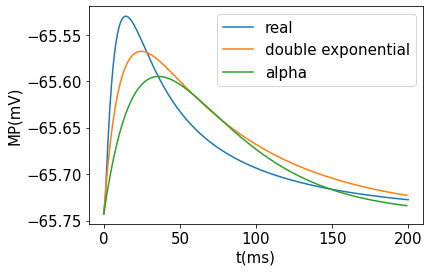

In [38]:
idx = 3
X = np.zeros((9, 1001))
X[idx, 0] = 1
y_b = model(X, Vars_bb[0:9], Vars_bb[9:18], Vars_bb[18:27], Vars_bb[27:63], Vars_bb[63])*np.std(Y_train)+np.mean(Y_train)
#y_non = model_non2(X, Vars_non[0:9], Vars_non[9:18], Vars_non[18:27], Vars_non[27], Vars_non[28], Vars_non[29])*np.std(Y_train)+np.mean(Y_train)
#y_l = model_l(X, Vars_l[0:9], Vars_l[9:18], Vars_l[18:27], Vars_l[27])*np.std(Y_train)+np.mean(Y_train)
y3 = model_old(X, Vars_old[0:9], Vars_old[9:18], Vars_old[18], Vars_old[19], Vars_old[20])*np.std(Y_train)+np.mean(Y_train)

plt.plot(Vsep[idx], label='real')
plt.plot(y_b[:200]+((min(Vsep[idx]))-min(y_b)), label='double exponential')
# plt.plot(y_non[:200]+((min(Vsep[idx]))-min(y_non)), label='nonlinear')
# plt.plot(y_l[:200]+((min(Vsep[idx]))-min(y_l)), label='linear')
plt.plot(y3[:200]+((min(Vsep[idx]))-min(y3)), label='alpha')

plt.xlabel('t(ms)')
plt.ylabel('MP(mV)')
plt.legend()
#plt.savefig('figure/kernel_compare_passive_con_2')

In [20]:
def biexponential(x, tau_rise, tau_decay):
    return (1 - np.exp(-x / tau_rise)) * np.exp(-x / tau_decay)

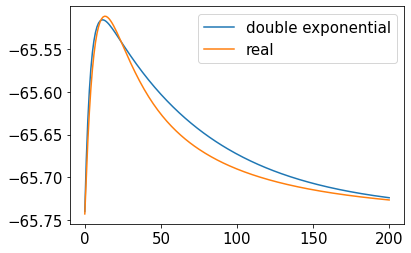

In [37]:
x = np.linspace(0, 200, 201)
y = 0.28 * biexponential(x, 4, 70)
y2 = 0.5 * biexponential(x, 6.5, 48.8)
plt.plot(y-65.74, label='double exponential')
plt.plot(Vsep[0], label='real')
plt.legend()
